In [1]:
#Tutorial: https://www.youtube.com/watch?v=Q5yVpymvjxU
#import
import numpy as np
import os
import cv2
import glob
import tifffile
from concurrent.futures import ProcessPoolExecutor, as_completed
from matplotlib import pyplot as plt
from skimage import filters, io, color,feature, img_as_ubyte, img_as_float
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.filters import gaussian, sobel, unsharp_mask, median,roberts, scharr, prewitt, farid
from skimage.morphology import disk
import bm3d
from skimage.color import rgb2gray
from skimage.restoration import denoise_bilateral,denoise_nl_means, estimate_sigma,denoise_tv_chambolle

In [2]:
FOLDER_NAME = 'filtros_results'
CURRENT_DIRECTORY = os.getcwd()
FOLDER_PATH = os.path.join(CURRENT_DIRECTORY, FOLDER_NAME)

In [3]:
path = "../Images_data/single_prediction/*.*"

images_list = [cv2.imread(file) for file in  glob.glob(path)]
images_gray_list = [img_as_float(io.imread(file, as_gray=True)) for file in glob.glob(path)]

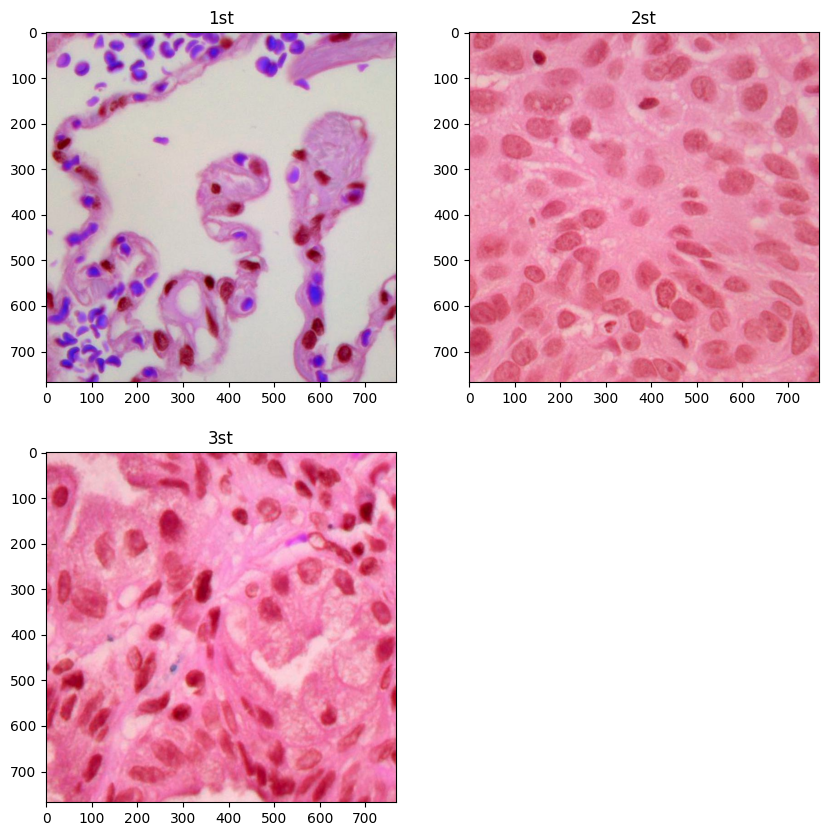

In [4]:
# view all images

fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(2,2,1)
ax1.imshow(images_list[0])
ax1.title.set_text('1st')

ax2 = fig.add_subplot(2,2,2)
ax2.imshow(images_list[1])
ax2.title.set_text('2st')

ax3 = fig.add_subplot(2,2,3)
ax3.imshow(images_list[2])
ax3.title.set_text('3st')

### Unsharp Filter

In [5]:
# filtro feito na mão
unsharp_filter = lambda img, sigma=2, mode='constant', cval=0.0 : img + ((img - gaussian(img, sigma=sigma, mode=mode, cval=cval)) * 2)
apply_unsharp = [unsharp_filter(img) for img in images_gray_list]

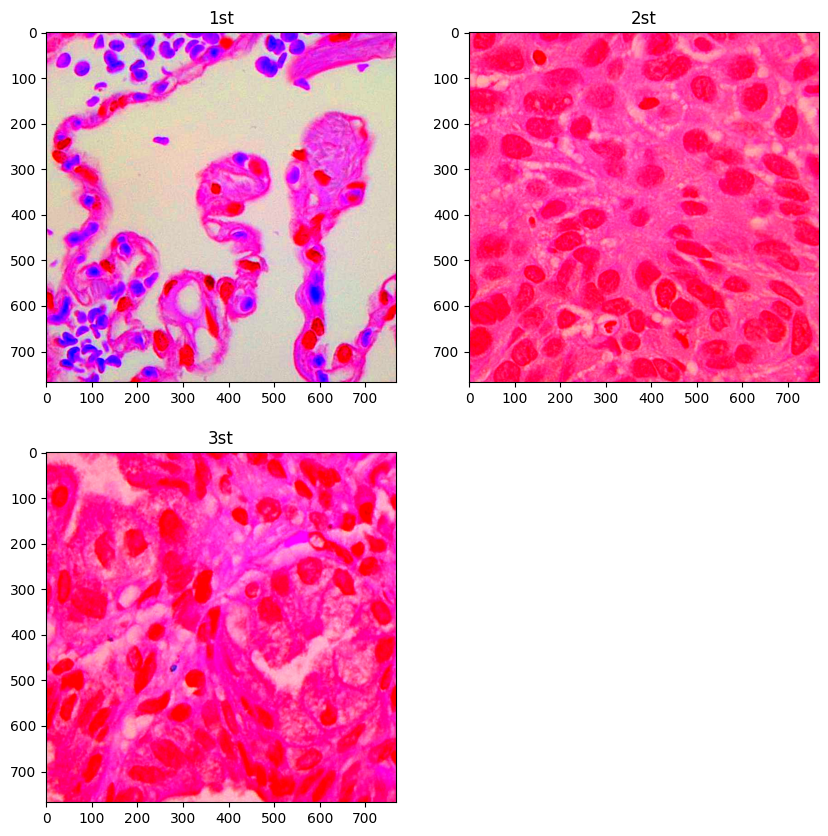

In [6]:
apply_unsharp = [unsharp_mask(img, radius=3, amount=2) for img in images_list]

fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(2,2,1)
ax1.imshow(apply_unsharp[0])
ax1.title.set_text('1st')

ax2 = fig.add_subplot(2,2,2)
ax2.imshow(apply_unsharp[1])
ax2.title.set_text('2st')

ax3 = fig.add_subplot(2,2,3)
ax3.imshow(apply_unsharp[2])
ax3.title.set_text('3st')

### Denoising

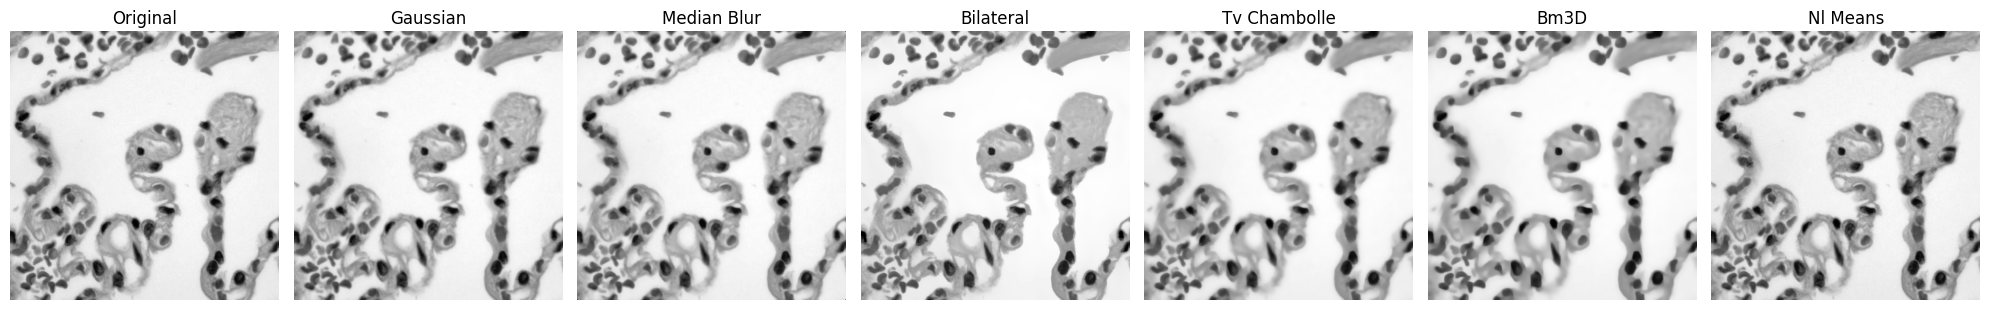

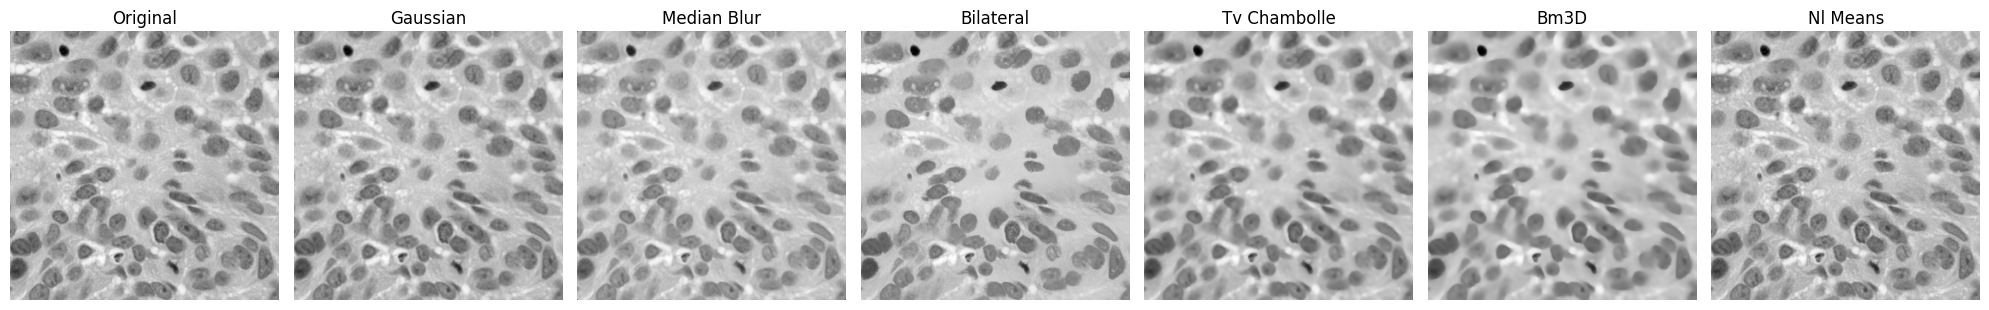

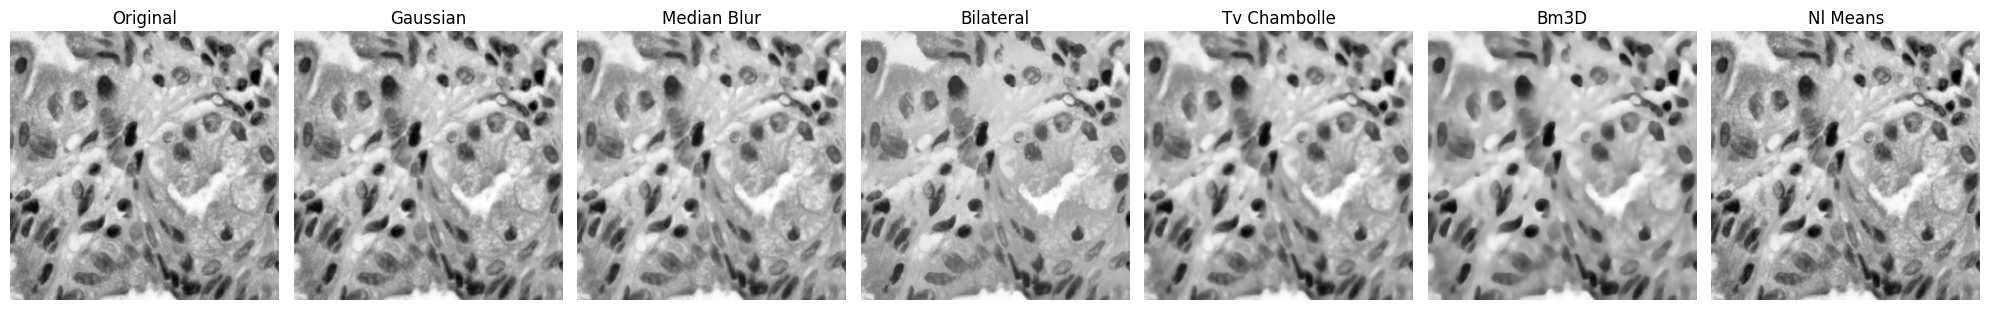

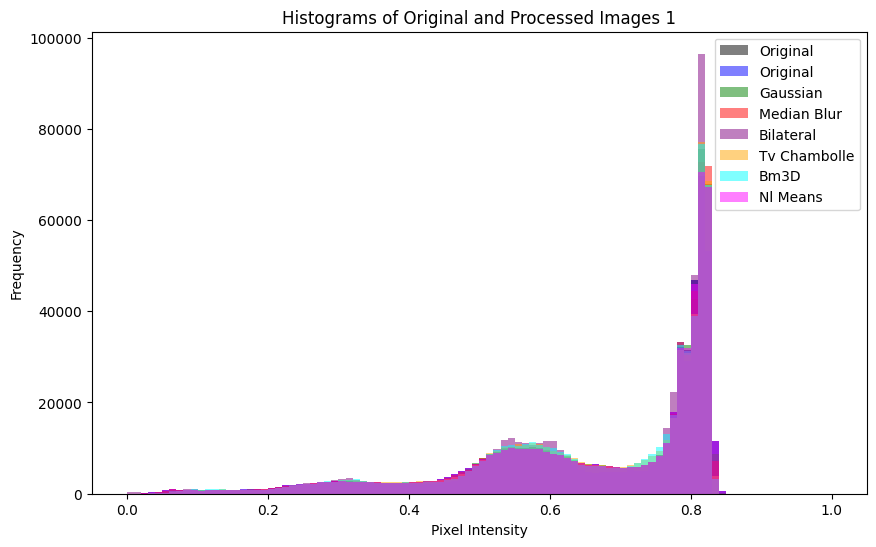

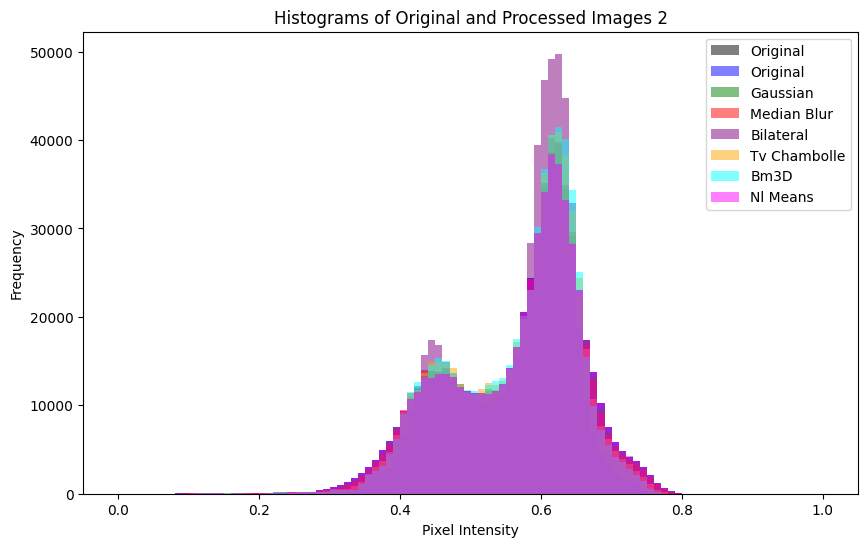

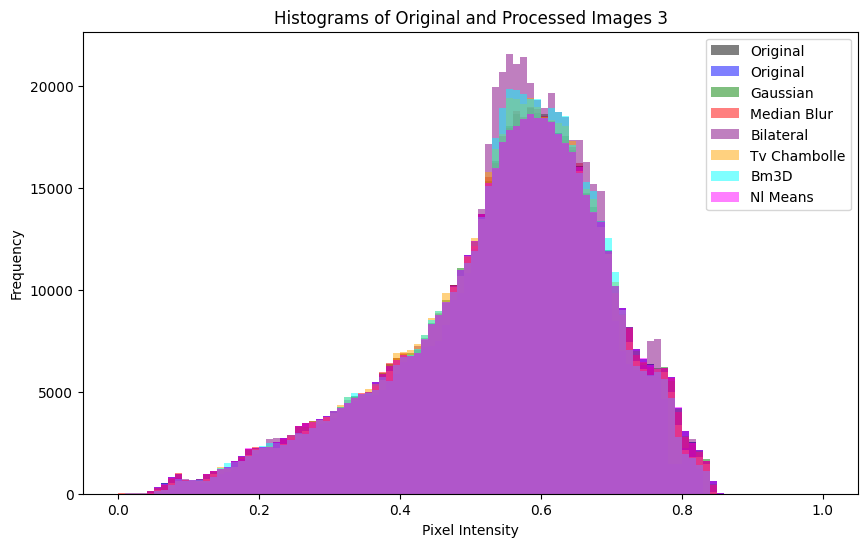

In [7]:
# Define functions for each processing step
def process_gaussian(img):
    return gaussian(img)

def process_median_blur(img):
    return median(img, disk(3), mode='constant', cval=0.0)

def process_bilateral(img):
    return denoise_bilateral(img, sigma_color=0.05, sigma_spatial=15, channel_axis=None)

def process_tv_chambolle(img):
    return denoise_tv_chambolle(img, weight=0.1, eps=0.0002, max_num_iter=200, channel_axis=None)

def process_BM3D(img):
    return bm3d.bm3d(img, sigma_psd=0.2, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)

def process_nl_means(img, h):
    return denoise_nl_means(img, h=h, fast_mode=True, patch_size=5, patch_distance=3, channel_axis=None)

# Estimate sigma for nl means denoising
sigma_est = lambda img : np.mean(estimate_sigma(img, channel_axis=None))

def process_images(images_gray_list):
    results = []
    # Use ProcessPoolExecutor for parallel processing
    with ProcessPoolExecutor() as executor:
        futures = []
        for img in images_gray_list:
            sigma = sigma_est(img)
            futures.append(executor.submit(process_gaussian, img))
            futures.append(executor.submit(process_median_blur, img))
            futures.append(executor.submit(process_bilateral, img))
            futures.append(executor.submit(process_tv_chambolle, img))
            futures.append(executor.submit(process_BM3D, img))
            futures.append(executor.submit(process_nl_means, img, sigma))
        
        for i in range(len(images_gray_list)):
            result = {
                "original": images_gray_list[i],
                "gaussian": futures[i*6].result(),
                "median_blur": futures[i*6+1].result(),
                "bilateral": futures[i*6+2].result(),
                "tv_chambolle": futures[i*6+3].result(),
                "BM3D": futures[i*6+4].result(),
                "nl_means": futures[i*6+5].result()
            }
            results.append(result)
    
    return results

def plot_images(results):
    image_counter = 0
    for result in results:
        image_counter += 1
        filter_names = list(result.keys())
        fig, axes = plt.subplots(1, len(filter_names), figsize=(20, 5))
        for idx, key in enumerate(filter_names):
            axes[idx].imshow(result[key], cmap='gray')
            axes[idx].set_title(key.replace('_', ' ').title())
            axes[idx].axis('off')
        plt.tight_layout()
        fig.get_figure() #'pega' o gráfico para salvar
        fig.savefig(f"filtros_results/plot_denoising_imagem_{image_counter}.png", facecolor='white') #salva o gráfico 
        plt.show()

def plot_histograms(images_gray_list, results):
    image_counter = 0
    colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta']
    
    for original_img, result in zip(images_gray_list, results):
        image_counter += 1
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Plot histogram for the original image
        plt.hist(original_img.flat, bins=100, range=(0, 1), alpha=0.5, label='Original', color='black')
        
        # Plot histograms for the processed images
        for idx, (filter_name, filtered_img) in enumerate(result.items()):
            plt.hist(filtered_img.flat, bins=100, range=(0, 1), alpha=0.5, label=filter_name.replace('_', ' ').title(), color=colors[idx % len(colors)])
        
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
        plt.legend()
        plt.title(f'Histograms of Original and Processed Images {image_counter}')
        fig.get_figure() #'pega' o gráfico para salvar
        fig.savefig(f"filtros_results/histograma_denoising_imagem_{image_counter}.png", facecolor='white') #salva o gráfico 
        plt.show()

results = process_images(images_gray_list)
plot_images(results)
plot_histograms(images_gray_list, results)


### Contorno

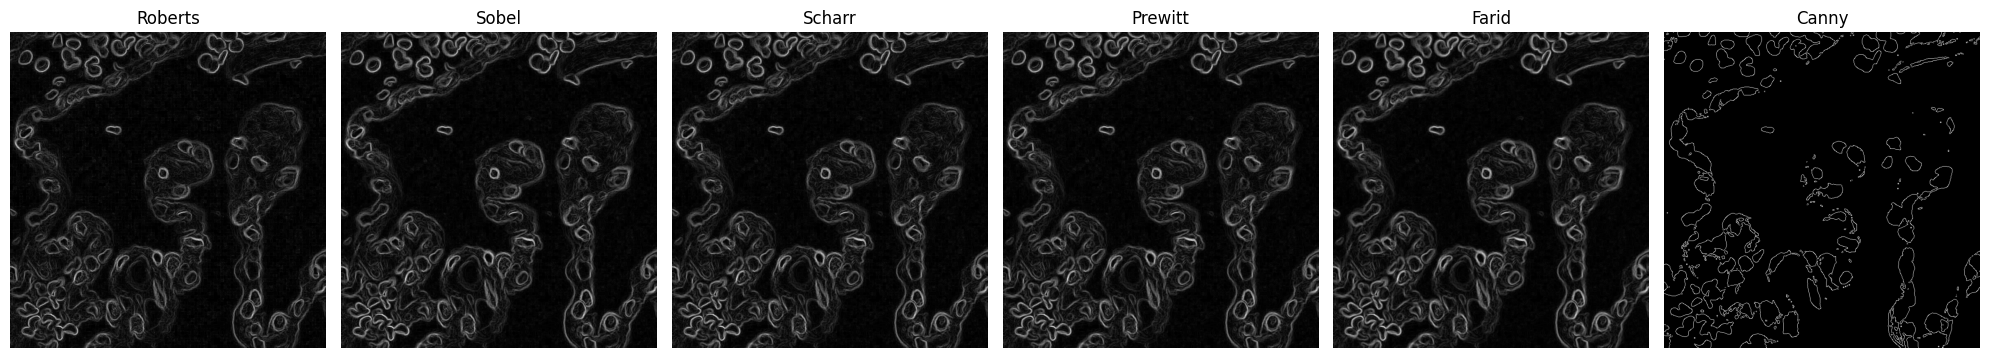

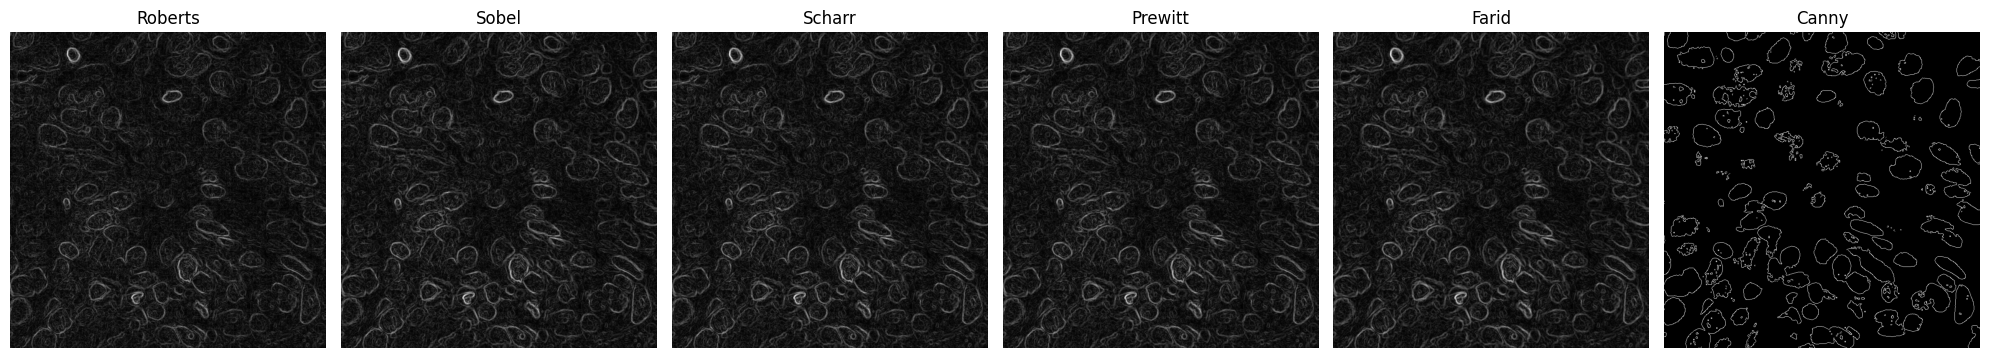

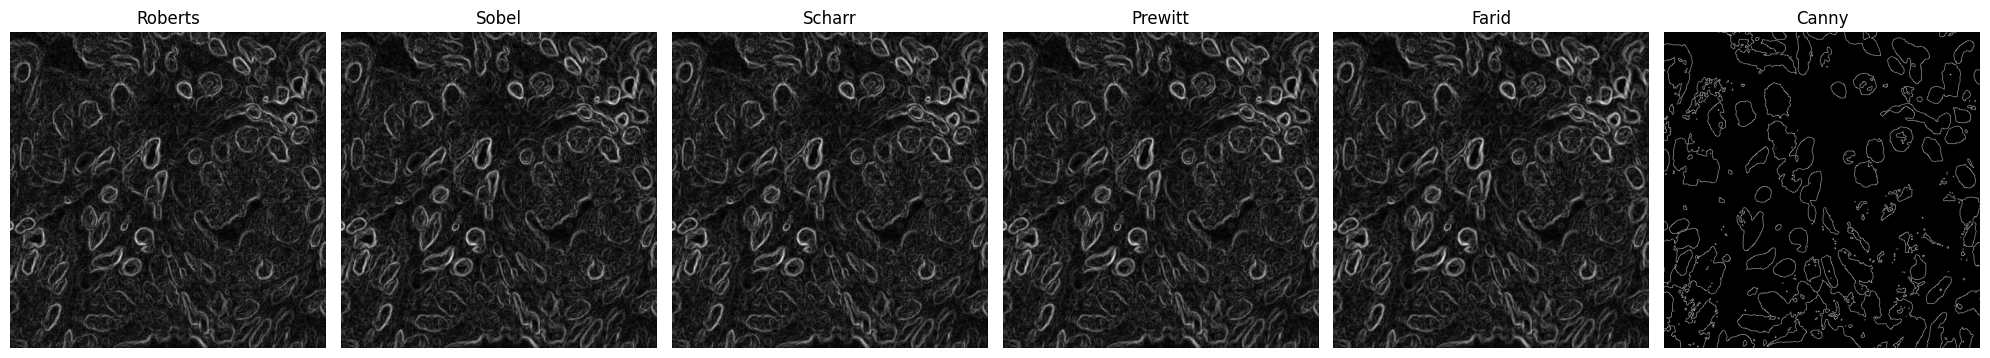

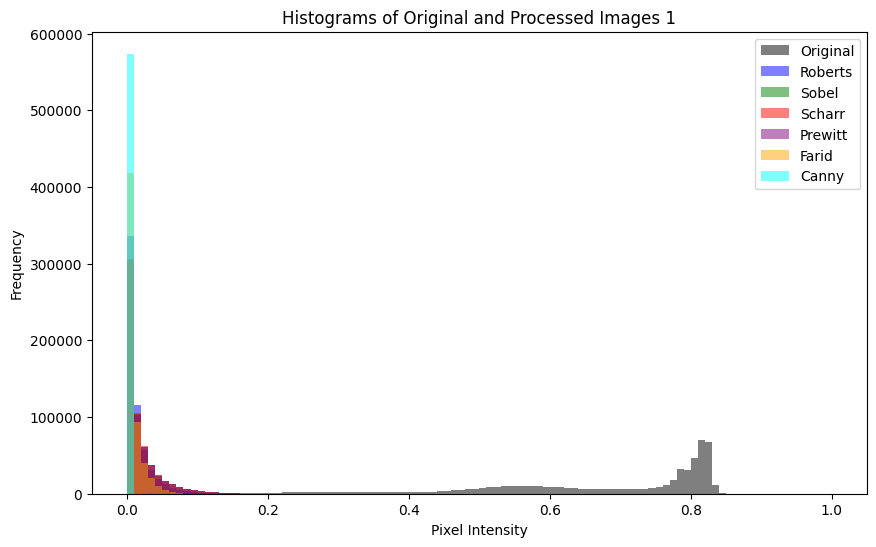

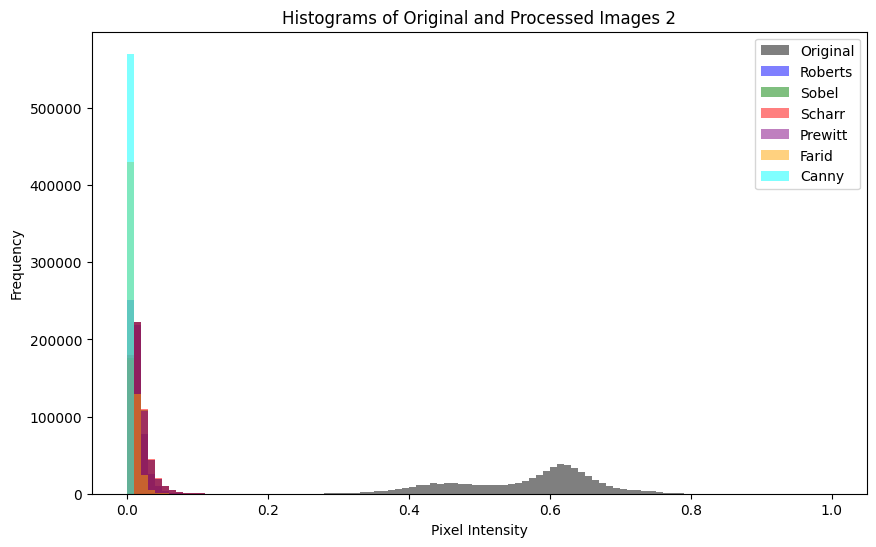

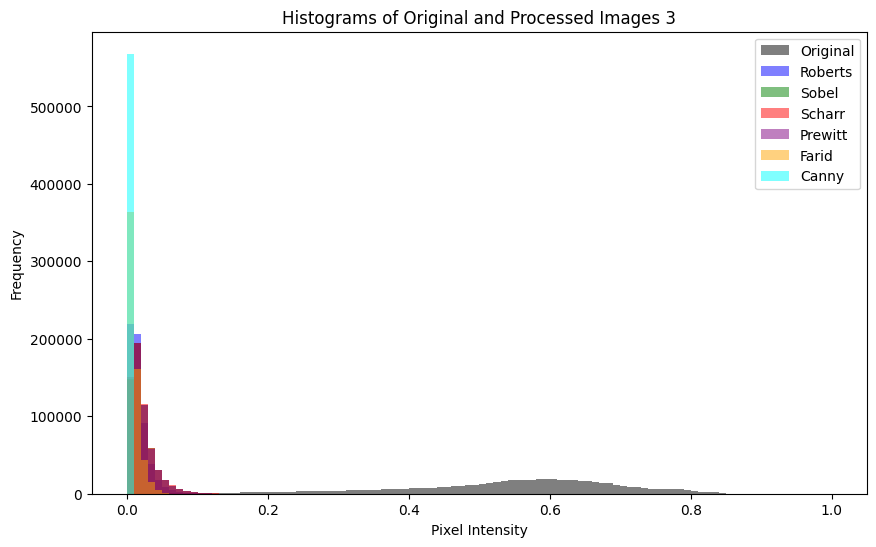

In [8]:
def process_roberts(img):
    return roberts(img)

def process_sobel(img):
    return sobel(img)

def process_scharr(img):
    return scharr(img)

def process_prewitt(img):
    return prewitt(img)

def process_farid(img):
    return farid(img)

def process_canny(img, sigma=0.3):
    img = cv2.convertScaleAbs(img)
    median_val = np.median(img)
    lower = int(max(0, (1.0 - sigma) * median_val))
    upper = int(min(255, (1.0 + sigma) * median_val))
    return cv2.Canny(img, lower, upper)

def process_images(images_gray_list):
    results = []
    with ProcessPoolExecutor() as executor:
        futures = []
        for img in images_gray_list:
            futures.append(executor.submit(process_roberts, img))
            futures.append(executor.submit(process_sobel, img))
            futures.append(executor.submit(process_scharr, img))
            futures.append(executor.submit(process_prewitt, img))
            futures.append(executor.submit(process_farid, img))
            futures.append(executor.submit(process_canny, img, sigma=0.3))
        
        num_filters = 6
        for i in range(len(images_gray_list)):
            result = {
                "roberts": futures[i * num_filters + 0].result(),
                "sobel": futures[i * num_filters + 1].result(),
                "scharr": futures[i * num_filters + 2].result(),
                "prewitt": futures[i * num_filters + 3].result(),
                "farid": futures[i * num_filters + 4].result(),
                "canny": futures[i * num_filters + 5].result()
            }
            results.append(result)
    
    return results

def plot_images(results):
    image_counter = 0
    for result in results:
        image_counter += 1
        filter_names = list(result.keys())
        fig, axes = plt.subplots(1, len(filter_names), figsize=(20, 5))
        for idx, key in enumerate(filter_names):
            axes[idx].imshow(result[key], cmap='gray')
            axes[idx].set_title(key.replace('_', ' ').title())
            axes[idx].axis('off')
        plt.tight_layout()
        fig.get_figure() #'pega' o gráfico para salvar
        fig.savefig(f"filtros_results/plot_contorno_imagem_{image_counter}.png", facecolor='white') #salva o gráfico 
        plt.show()

def plot_histograms(images_gray_list, results):
    image_counter = 0
    colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta']
    
    for original_img, result in zip(images_gray_list, results):
        image_counter += 1
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Plot histogram for the original image
        plt.hist(original_img.flat, bins=100, range=(0, 1), alpha=0.5, label='Original', color='black')
        
        # Plot histograms for the processed images
        for idx, (filter_name, filtered_img) in enumerate(result.items()):
            plt.hist(filtered_img.flat, bins=100, range=(0, 1), alpha=0.5, label=filter_name.replace('_', ' ').title(), color=colors[idx % len(colors)])
        
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
        plt.legend()
        plt.title(f'Histograms of Original and Processed Images {image_counter}')
        fig.get_figure() #'pega' o gráfico para salvar
        fig.savefig(f"filtros_results/histograma_contorno_imagem_{image_counter}.png", facecolor='white') #salva o gráfico 
        plt.show()

results = process_images(images_gray_list)
plot_images(results)
plot_histograms(images_gray_list, results)
